In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from shapely.ops import unary_union
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")
from sklearn.decomposition import PCA
from sklearn import decomposition
from scipy import stats
from scipy.stats import zscore

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import RobustScaler


import os



/opt/homebrew/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/rr/9mckj0xn5jv_p1y1j15mbncm0000gn/T/ipykernel_10825/3084144981.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.rea

# Read csv

In [4]:
gentrification_lsoa_code = pd.read_csv("data/Output/overlap_PCA/intersect_part3_same_lsoa.csv")
origin_data_census = pd.read_csv("data/identified_neiborhood_data_2011_2021.csv")
LSOA2021_code = pd.read_csv("data/LSOA2021_London_code.csv")
park_data = pd.read_csv("data/link_lsoa2021_park.csv")
original_identified_neiborhood_data_2011_2021 = pd.read_csv("data/classifed_neibor_change.csv")
perpared_for_regression_standardized = pd.read_csv("data/perpared_for_regression.csv")
airbnb_data = pd.read_csv("data/airbnb_LSOA2021.csv")
poi_data = pd.read_csv("data/link_poi_data.csv")

In [5]:
len(perpared_for_regression_standardized)

4994

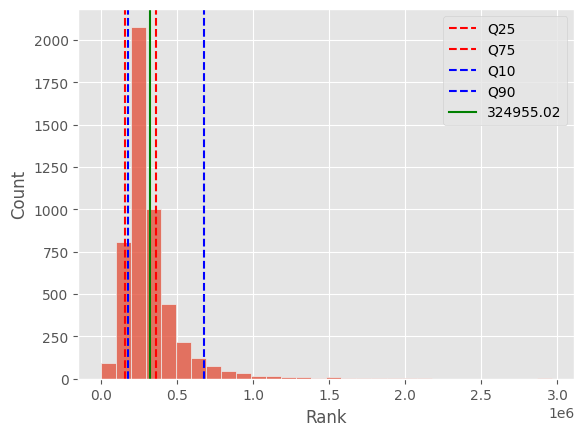

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# calculate the quantiles
q25 = original_identified_neiborhood_data_2011_2021["mediam_price_2011"].quantile(0.05)
q75 = original_identified_neiborhood_data_2011_2021["mediam_price_2011"].quantile(0.75)
q10 = original_identified_neiborhood_data_2011_2021["mediam_price_2011"].quantile(0.10)
q90 = original_identified_neiborhood_data_2011_2021["mediam_price_2011"].quantile(0.95)

# create the histogram
sns.histplot(original_identified_neiborhood_data_2011_2021["mediam_price_2011"], bins=30, kde=False)

# draw the lines for quantiles
plt.axvline(q25, color='red', linestyle='--', label='Q25')
plt.axvline(q75, color='red', linestyle='--', label='Q75')
plt.axvline(q10, color='blue', linestyle='--', label='Q10')
plt.axvline(q90, color='blue', linestyle='--', label='Q90')

# draw the line for the specified value
plt.axvline(324955.01755070203, color='green', linestyle='-', label='324955.02')

# add legend and labels
plt.legend()
plt.xlabel('Rank')
plt.ylabel('Count')

# display the plot
plt.show()

In [7]:
original_identified_neiborhood_data_2011_2021["mediam_price_2011"].mean()

322824.82609130954

In [8]:
original_identified_neiborhood_data_2011_2021["mediam_price_2011"].quantile(0.05)

155000.0

In [9]:
original_identified_neiborhood_data_2011_2021["mediam_price_2011"].quantile(0.25)

215000.0

In [10]:
from scipy.stats import zscore

In [11]:
original_identified_neiborhood_data_2011_2021["more_low_price"] = (original_identified_neiborhood_data_2011_2021["mediam_price_2011"] < 215000).astype(int)
original_identified_neiborhood_data_2011_2021["low_price"] = (original_identified_neiborhood_data_2011_2021["mediam_price_2011"] < 155000).astype(int)
original_identified_neiborhood_data_2011_2021["low_than_mediam_price"] = (original_identified_neiborhood_data_2011_2021["mediam_price_2011"] < 323386).astype(int)

In [12]:
original_identified_neiborhood_data_2011_2021["more_low_price_z"] = zscore(original_identified_neiborhood_data_2011_2021["more_low_price"])
original_identified_neiborhood_data_2011_2021["low_price_z"] = zscore(original_identified_neiborhood_data_2011_2021["low_price"])

In [13]:
original_identified_neiborhood_data_2011_2021["born_in_uk_change_pct"] = original_identified_neiborhood_data_2011_2021["born_in_the_UK_2021_pct"] - original_identified_neiborhood_data_2011_2021["born_in_the_UK_2011_pct"]

In [14]:
airbnb_data.head()

,LSOA21CD,num_airbnb_12_21,density_airbnb,num_airbnb_rank,airbnb_total_price_2012_2021,num_airbnb_2012_2021,average_price_2012_2021
0,E01000001,11,0.008224,59.462389,1427,11,129.727273
1,E01000002,12,0.005317,62.020377,1740,12,145.000000
2,E01000003,14,0.024438,66.442662,1228,14,87.714286
3,E01000005,79,0.041468,98.428355,11491,79,145.455696
4,E01000006,6,0.004161,42.022545,363,6,60.500000


In [15]:
airbnb_data["density_airbnb"].median()

0.002917118

In [16]:
len(gentrification_lsoa_code)

709

# Mark gentrification

In [17]:
gentrification_lsoa_code_2 = gentrification_lsoa_code['LSOA21CD'].unique()
LSOA2021_code['gen'] = LSOA2021_code['LSOA21CD'].isin(gentrification_lsoa_code_2).astype(int)
mask = LSOA2021_code["gen"] == 1  
print(len(LSOA2021_code.loc[mask, "LSOA21CD"])) 

709


In [18]:
LSOA2021_code

,LSOA21CD,gen
0,E01000001,0
1,E01000002,1
2,E01000003,1
3,E01000005,0
4,E01000006,0
...,...,...
4989,E01035718,1
4990,E01035719,0
4991,E01035720,0
4992,E01035721,1


# Calculate data

In [19]:
perpared_for_regression_standardized["more_low_price"] = original_identified_neiborhood_data_2011_2021["more_low_price"]
perpared_for_regression_standardized["low_price"] = original_identified_neiborhood_data_2011_2021["low_price"]
perpared_for_regression_standardized["low_than_mediam_price"] = original_identified_neiborhood_data_2011_2021["low_than_mediam_price"]
perpared_for_regression_standardized["born_in_uk_change_pct"] = original_identified_neiborhood_data_2011_2021["born_in_uk_change_pct"]
perpared_for_regression_standardized["religionNo_religion_change_pct"] = original_identified_neiborhood_data_2011_2021["religionNo_religion_2021_pct"] - original_identified_neiborhood_data_2011_2021["religionNo_religion_2011_pct"]


In [20]:
perpared_for_regression_standardized = perpared_for_regression_standardized.fillna(0)

In [21]:
perpared_for_regression_standardized

,LSOA21CD,housing_price_change_pct,housing_mediam_price_change_pct,young_people_change_pct,middle_aged_people_change_pct,more_65_people_change_pct,older_middle_aged_people_change_pct,household_more_65_change_pct,household_no_children_change_pct,household_dependent_children_change_pct,...,Conversion_2011_2018_pct,average_chn_11_19,income_score_change,park_area,park_density,to_park_in_300m,more_low_price,low_price,low_than_mediam_price,born_in_uk_change_pct
0,E01000001,0.663366,0.669865,1.81,0.01,6.83,-9.48,5.57,2.02,1.64,...,0.005497,0.140000,-0.0040,3.934120e+04,29.412003,1,0,0,0,-7.97
1,E01000002,0.549763,0.503733,4.44,2.50,1.28,-4.75,-0.22,-0.55,-3.92,...,0.165370,0.130000,0.0220,6.628189e+04,29.370635,1,0,0,0,-18.14
2,E01000003,0.270140,0.026986,0.23,0.10,-1.20,5.70,-4.23,5.94,-1.25,...,0.135594,0.150000,-0.0190,3.524176e+04,61.516391,1,0,0,0,-10.25
3,E01000005,0.000000,0.000000,0.87,-0.85,-3.44,3.55,-3.45,1.47,0.29,...,0.052222,0.130000,-0.0060,0.000000e+00,0.000000,0,1,1,1,-9.57
4,E01000006,0.704782,0.826443,-0.84,-6.56,0.77,5.79,1.10,-4.75,0.91,...,0.000000,0.260000,-0.0160,0.000000e+00,0.000000,0,0,0,1,-0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,E01035718,0.728142,0.735924,-0.30,-4.44,1.11,2.21,3.97,-1.23,6.08,...,0.019240,0.250000,-0.0005,2.222580e+06,83.147099,1,0,0,0,-1.17
4990,E01035719,0.309091,0.161800,3.00,-2.16,-2.27,0.33,-2.72,-2.77,3.04,...,0.001832,0.071530,-0.0280,0.000000e+00,0.000000,1,0,0,0,-16.53
4991,E01035720,0.309091,0.161800,3.75,-6.00,-3.45,4.47,-1.90,-4.33,2.20,...,0.000458,0.085672,-0.0280,0.000000e+00,0.000000,1,0,0,0,-6.20
4992,E01035721,3.809873,5.511286,-1.26,-3.16,-2.36,6.85,-4.67,-3.02,-0.86,...,0.017407,0.280000,-0.0130,0.000000e+00,0.000000,1,0,0,0,-5.92


In [22]:
original_data = perpared_for_regression_standardized.copy()

In [23]:
original_data = original_data.merge(LSOA2021_code, left_on="LSOA21CD", right_on="LSOA21CD", how="inner")
poi_data =poi_data.merge(LSOA2021_code, left_on="LSOA21CD", right_on="LSOA21CD", how="inner")
airbnb_data = airbnb_data.merge(LSOA2021_code, left_on="LSOA21CD", right_on="LSOA21CD", how="inner")

In [24]:
original_data["airbnb_average_price"] = zscore(airbnb_data["average_price_2012_2021"])
original_data["density_airbnb"] = airbnb_data["density_airbnb"]

In [25]:
original_data = original_data.merge(poi_data, on = "LSOA21CD", how = "left")
original_data = original_data.fillna(0)


In [26]:
original_data

,LSOA21CD,housing_price_change_pct,housing_mediam_price_change_pct,young_people_change_pct,middle_aged_people_change_pct,more_65_people_change_pct,older_middle_aged_people_change_pct,household_more_65_change_pct,household_no_children_change_pct,household_dependent_children_change_pct,...,more_low_price,low_price,low_than_mediam_price,born_in_uk_change_pct,gen_x,airbnb_average_price,density_airbnb,cafe_other_pct,school_pct,gen_y
0,E01000001,0.663366,0.669865,1.81,0.01,6.83,-9.48,5.57,2.02,1.64,...,0,0,0,-7.97,0,0.329179,0.008224,0.016634,0.015137,0
1,E01000002,0.549763,0.503733,4.44,2.50,1.28,-4.75,-0.22,-0.55,-3.92,...,0,0,0,-18.14,1,0.466385,0.005317,0.010659,0.000000,1
2,E01000003,0.270140,0.026986,0.23,0.10,-1.20,5.70,-4.23,5.94,-1.25,...,0,0,0,-10.25,1,-0.048254,0.024438,0.010003,0.060850,1
3,E01000005,0.000000,0.000000,0.87,-0.85,-3.44,3.55,-3.45,1.47,0.29,...,1,1,1,-9.57,0,0.470479,0.041468,0.002481,0.018249,0
4,E01000006,0.704782,0.826443,-0.84,-6.56,0.77,5.79,1.10,-4.75,0.91,...,0,0,1,-0.47,0,-0.292739,0.004161,0.000000,0.037239,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,E01035718,0.728142,0.735924,-0.30,-4.44,1.11,2.21,3.97,-1.23,6.08,...,0,0,0,-1.17,1,2.543400,0.006435,0.004217,0.000000,1
4990,E01035719,0.309091,0.161800,3.00,-2.16,-2.27,0.33,-2.72,-2.77,3.04,...,0,0,0,-16.53,0,0.411584,0.011031,0.000000,0.000000,0
4991,E01035720,0.309091,0.161800,3.75,-6.00,-3.45,4.47,-1.90,-4.33,2.20,...,0,0,0,-6.20,0,0.787179,0.022104,0.000000,0.001214,0
4992,E01035721,3.809873,5.511286,-1.26,-3.16,-2.36,6.85,-4.67,-3.02,-0.86,...,0,0,0,-5.92,1,1.361695,0.020214,0.000261,0.002878,1


# score function

In [27]:
def data_merge(data, data2):
    data = data.merge(data2, on="LSOA21CD")
    return data

In [28]:
binary_data = original_data.copy()

In [29]:

binary_data['park_binary'] = original_data['park_density'].apply(lambda x: 1 if x > 0.4927646145 else 0)
binary_data['airbnb_binary'] = airbnb_data['density_airbnb'].apply(lambda x: 1 if x > 0.002917118 else 0)
binary_data 


,LSOA21CD,housing_price_change_pct,housing_mediam_price_change_pct,young_people_change_pct,middle_aged_people_change_pct,more_65_people_change_pct,older_middle_aged_people_change_pct,household_more_65_change_pct,household_no_children_change_pct,household_dependent_children_change_pct,...,low_than_mediam_price,born_in_uk_change_pct,gen_x,airbnb_average_price,density_airbnb,cafe_other_pct,school_pct,gen_y,park_binary,airbnb_binary
0,E01000001,0.663366,0.669865,1.81,0.01,6.83,-9.48,5.57,2.02,1.64,...,0,-7.97,0,0.329179,0.008224,0.016634,0.015137,0,1,1
1,E01000002,0.549763,0.503733,4.44,2.50,1.28,-4.75,-0.22,-0.55,-3.92,...,0,-18.14,1,0.466385,0.005317,0.010659,0.000000,1,1,1
2,E01000003,0.270140,0.026986,0.23,0.10,-1.20,5.70,-4.23,5.94,-1.25,...,0,-10.25,1,-0.048254,0.024438,0.010003,0.060850,1,1,1
3,E01000005,0.000000,0.000000,0.87,-0.85,-3.44,3.55,-3.45,1.47,0.29,...,1,-9.57,0,0.470479,0.041468,0.002481,0.018249,0,0,1
4,E01000006,0.704782,0.826443,-0.84,-6.56,0.77,5.79,1.10,-4.75,0.91,...,1,-0.47,0,-0.292739,0.004161,0.000000,0.037239,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,E01035718,0.728142,0.735924,-0.30,-4.44,1.11,2.21,3.97,-1.23,6.08,...,0,-1.17,1,2.543400,0.006435,0.004217,0.000000,1,1,1
4990,E01035719,0.309091,0.161800,3.00,-2.16,-2.27,0.33,-2.72,-2.77,3.04,...,0,-16.53,0,0.411584,0.011031,0.000000,0.000000,0,0,1
4991,E01035720,0.309091,0.161800,3.75,-6.00,-3.45,4.47,-1.90,-4.33,2.20,...,0,-6.20,0,0.787179,0.022104,0.000000,0.001214,0,0,1
4992,E01035721,3.809873,5.511286,-1.26,-3.16,-2.36,6.85,-4.67,-3.02,-0.86,...,0,-5.92,1,1.361695,0.020214,0.000261,0.002878,1,0,1


In [30]:
nor_data_psm = data_merge(original_data, LSOA2021_code).fillna(0)

In [31]:

nor_data_psm["park_binary"] = binary_data["park_binary"]

In [32]:

nor_data_psm['airbnb_binary'] = binary_data['airbnb_binary']
nor_data_psm["compared_mean_price_2011"] = origin_data_census["compared_mean_price_2011"]
nor_data_psm["compared_mean_price_2021"] = origin_data_census["compared_mean_price_2021"]
nor_data_psm["mediam_price_2021"] = origin_data_census["mediam_price_2021"]
nor_data_psm["mediam_price_2011"] = origin_data_census["mediam_price_2011"]
nor_data_psm["Driving_a_car_or_van_change_pct"] = original_identified_neiborhood_data_2011_2021["Driving_a_car_or_van_2021_pct"] - original_identified_neiborhood_data_2011_2021["Driving_a_car_or_van_2011_pct"]
nor_data_psm["going_to_work_by_van_change_pct"] = nor_data_psm["Driving_a_car_or_van_change_pct"] + nor_data_psm["Passenger_in_a_car_or_van_change_pct"]

In [33]:
nor_data_psm

,LSOA21CD,housing_price_change_pct,housing_mediam_price_change_pct,young_people_change_pct,middle_aged_people_change_pct,more_65_people_change_pct,older_middle_aged_people_change_pct,household_more_65_change_pct,household_no_children_change_pct,household_dependent_children_change_pct,...,gen_y,gen,park_binary,airbnb_binary,compared_mean_price_2011,compared_mean_price_2021,mediam_price_2021,mediam_price_2011,Driving_a_car_or_van_change_pct,going_to_work_by_van_change_pct
0,E01000001,0.663366,0.669865,1.81,0.01,6.83,-9.48,5.57,2.02,1.64,...,0,0,1,1,339092.0,566238,840000,505000.0,-0.62,-0.89
1,E01000002,0.549763,0.503733,4.44,2.50,1.28,-4.75,-0.22,-0.55,-3.92,...,1,1,1,1,361592.0,543738,817500,527500.0,-0.30,-0.15
2,E01000003,0.270140,0.026986,0.23,0.10,-1.20,5.70,-4.23,5.94,-1.25,...,1,1,1,1,259242.0,266238,540000,425150.0,-0.66,-0.30
3,E01000005,0.000000,0.000000,0.87,-0.85,-3.44,3.55,-3.45,1.47,0.29,...,0,0,0,1,0.0,0,0,0.0,0.46,0.35
4,E01000006,0.704782,0.826443,-0.84,-6.56,0.77,5.79,1.10,-4.75,0.91,...,0,0,0,1,74592.0,136238,410000,240500.0,-0.72,-0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,E01035718,0.728142,0.735924,-0.30,-4.44,1.11,2.21,3.97,-1.23,6.08,...,1,1,1,1,1664092.0,2888738,3162500,1830000.0,-1.86,-2.19
4990,E01035719,0.309091,0.161800,3.00,-2.16,-2.27,0.33,-2.72,-2.77,3.04,...,0,0,0,1,384092.0,446238,720000,550000.0,-2.38,-2.07
4991,E01035720,0.309091,0.161800,3.75,-6.00,-3.45,4.47,-1.90,-4.33,2.20,...,0,0,0,1,384092.0,446238,720000,550000.0,-0.96,-1.04
4992,E01035721,3.809873,5.511286,-1.26,-3.16,-2.36,6.85,-4.67,-3.02,-0.86,...,1,1,0,1,308117.0,2006238,2280000,474025.0,-2.27,-2.55


In [34]:
print(len(nor_data_psm))

4994


# regression

In [35]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [36]:
regression_columns =  ["NSSES_1_change_pct","NSSES_2_change_pct",\
                     'NSSES_3_change_pct', 'NSSES_4_change_pct',"NSSES_5_change_pct","NSSES_6_change_pct",\
                    "NSSES_7_change_pct","Administrative_and_secretarial_occupations_change_pct","Work_mainly_at_or_from_home_change_pct","going_to_work_by_van_change_pct",\
                    "converted_or_share_house_change_pct","average_chn_11_19",\
                    "mediam_price_2021","mediam_price_2011","Full_time_31_to_48_hours_change_pct"]

In [38]:
data_for_plot = nor_data_psm[regression_columns]

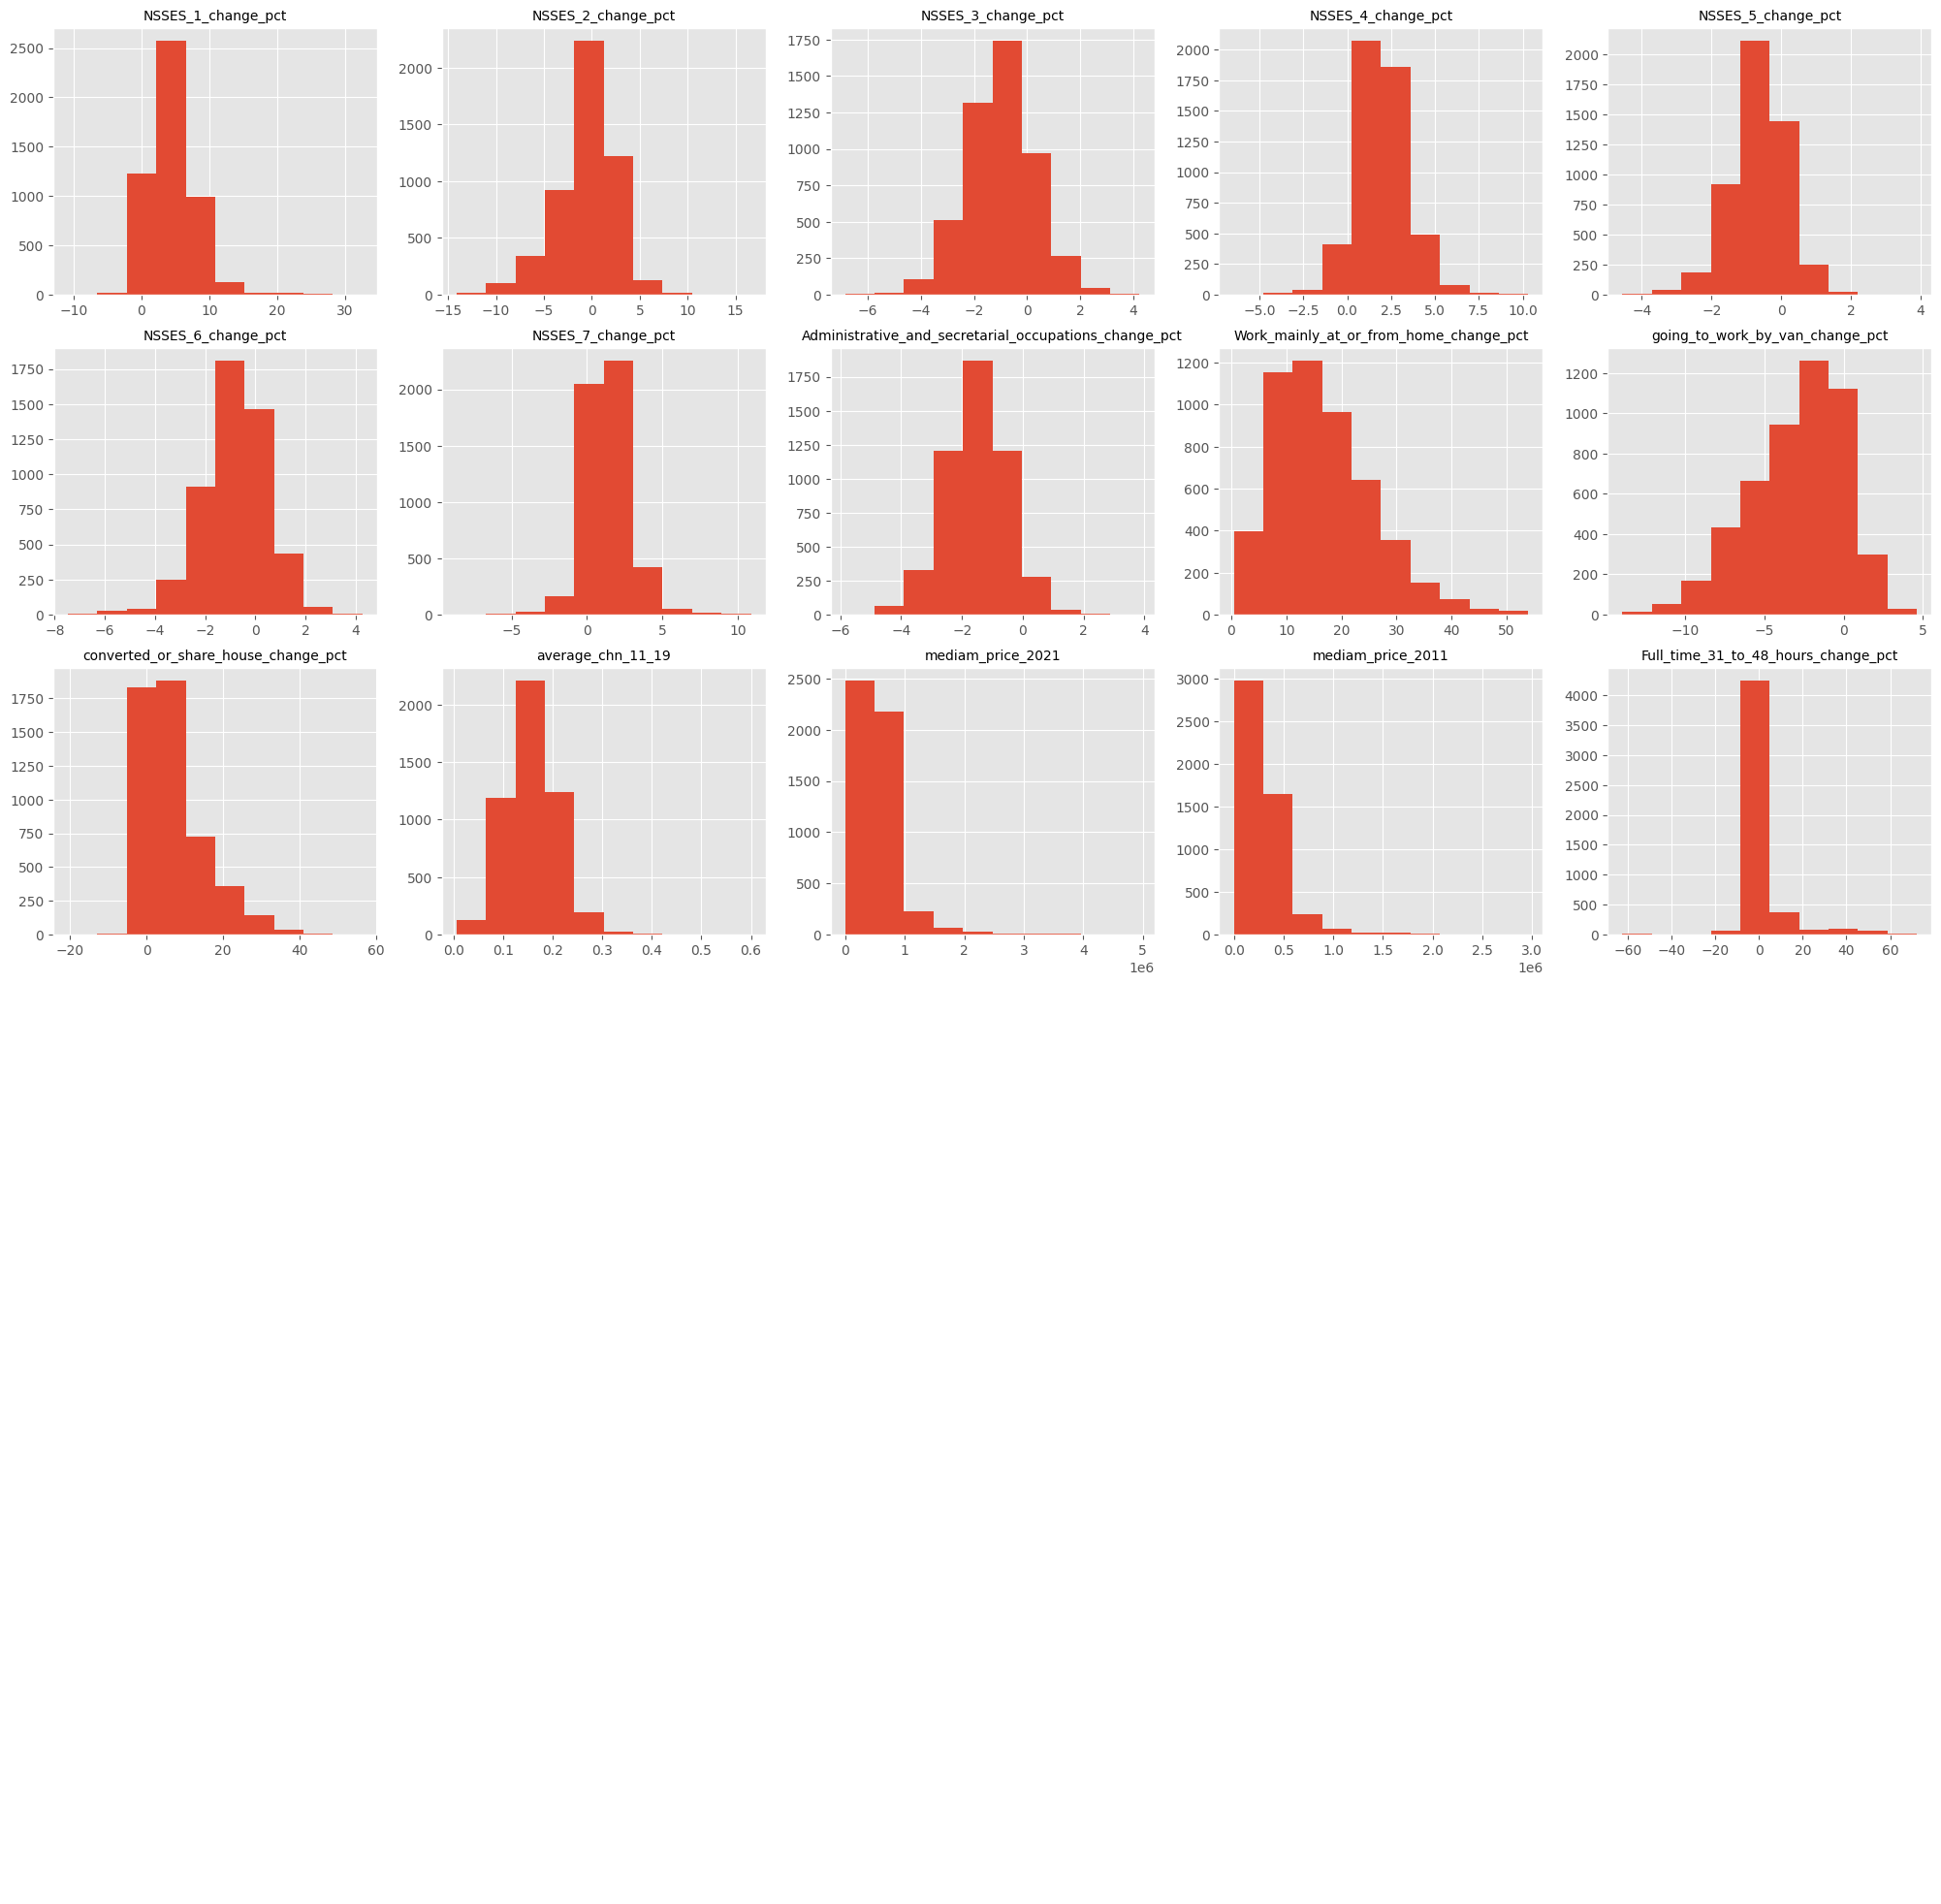

In [39]:
num_row = 6
num_col = 5
fig, axes = plt.subplots(nrows= num_row, ncols= num_col, figsize=(25, 25))

counter = 0
for i in range(num_row):
    for j in range(num_col):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len( data_for_plot.columns):

            ax.hist(data_for_plot[ data_for_plot.columns[counter]], label='{}'.format( data_for_plot.columns[counter]))
            ax.set_title( data_for_plot.columns[counter], fontsize=10)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1
        
plt.show()

In [41]:
from sklearn.preprocessing import PowerTransformer

yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

yeo_trans = yeo_johnson_transformer.fit_transform(nor_data_psm[regression_columns])
yeo_trans_data = pd.DataFrame(yeo_trans, columns=regression_columns)



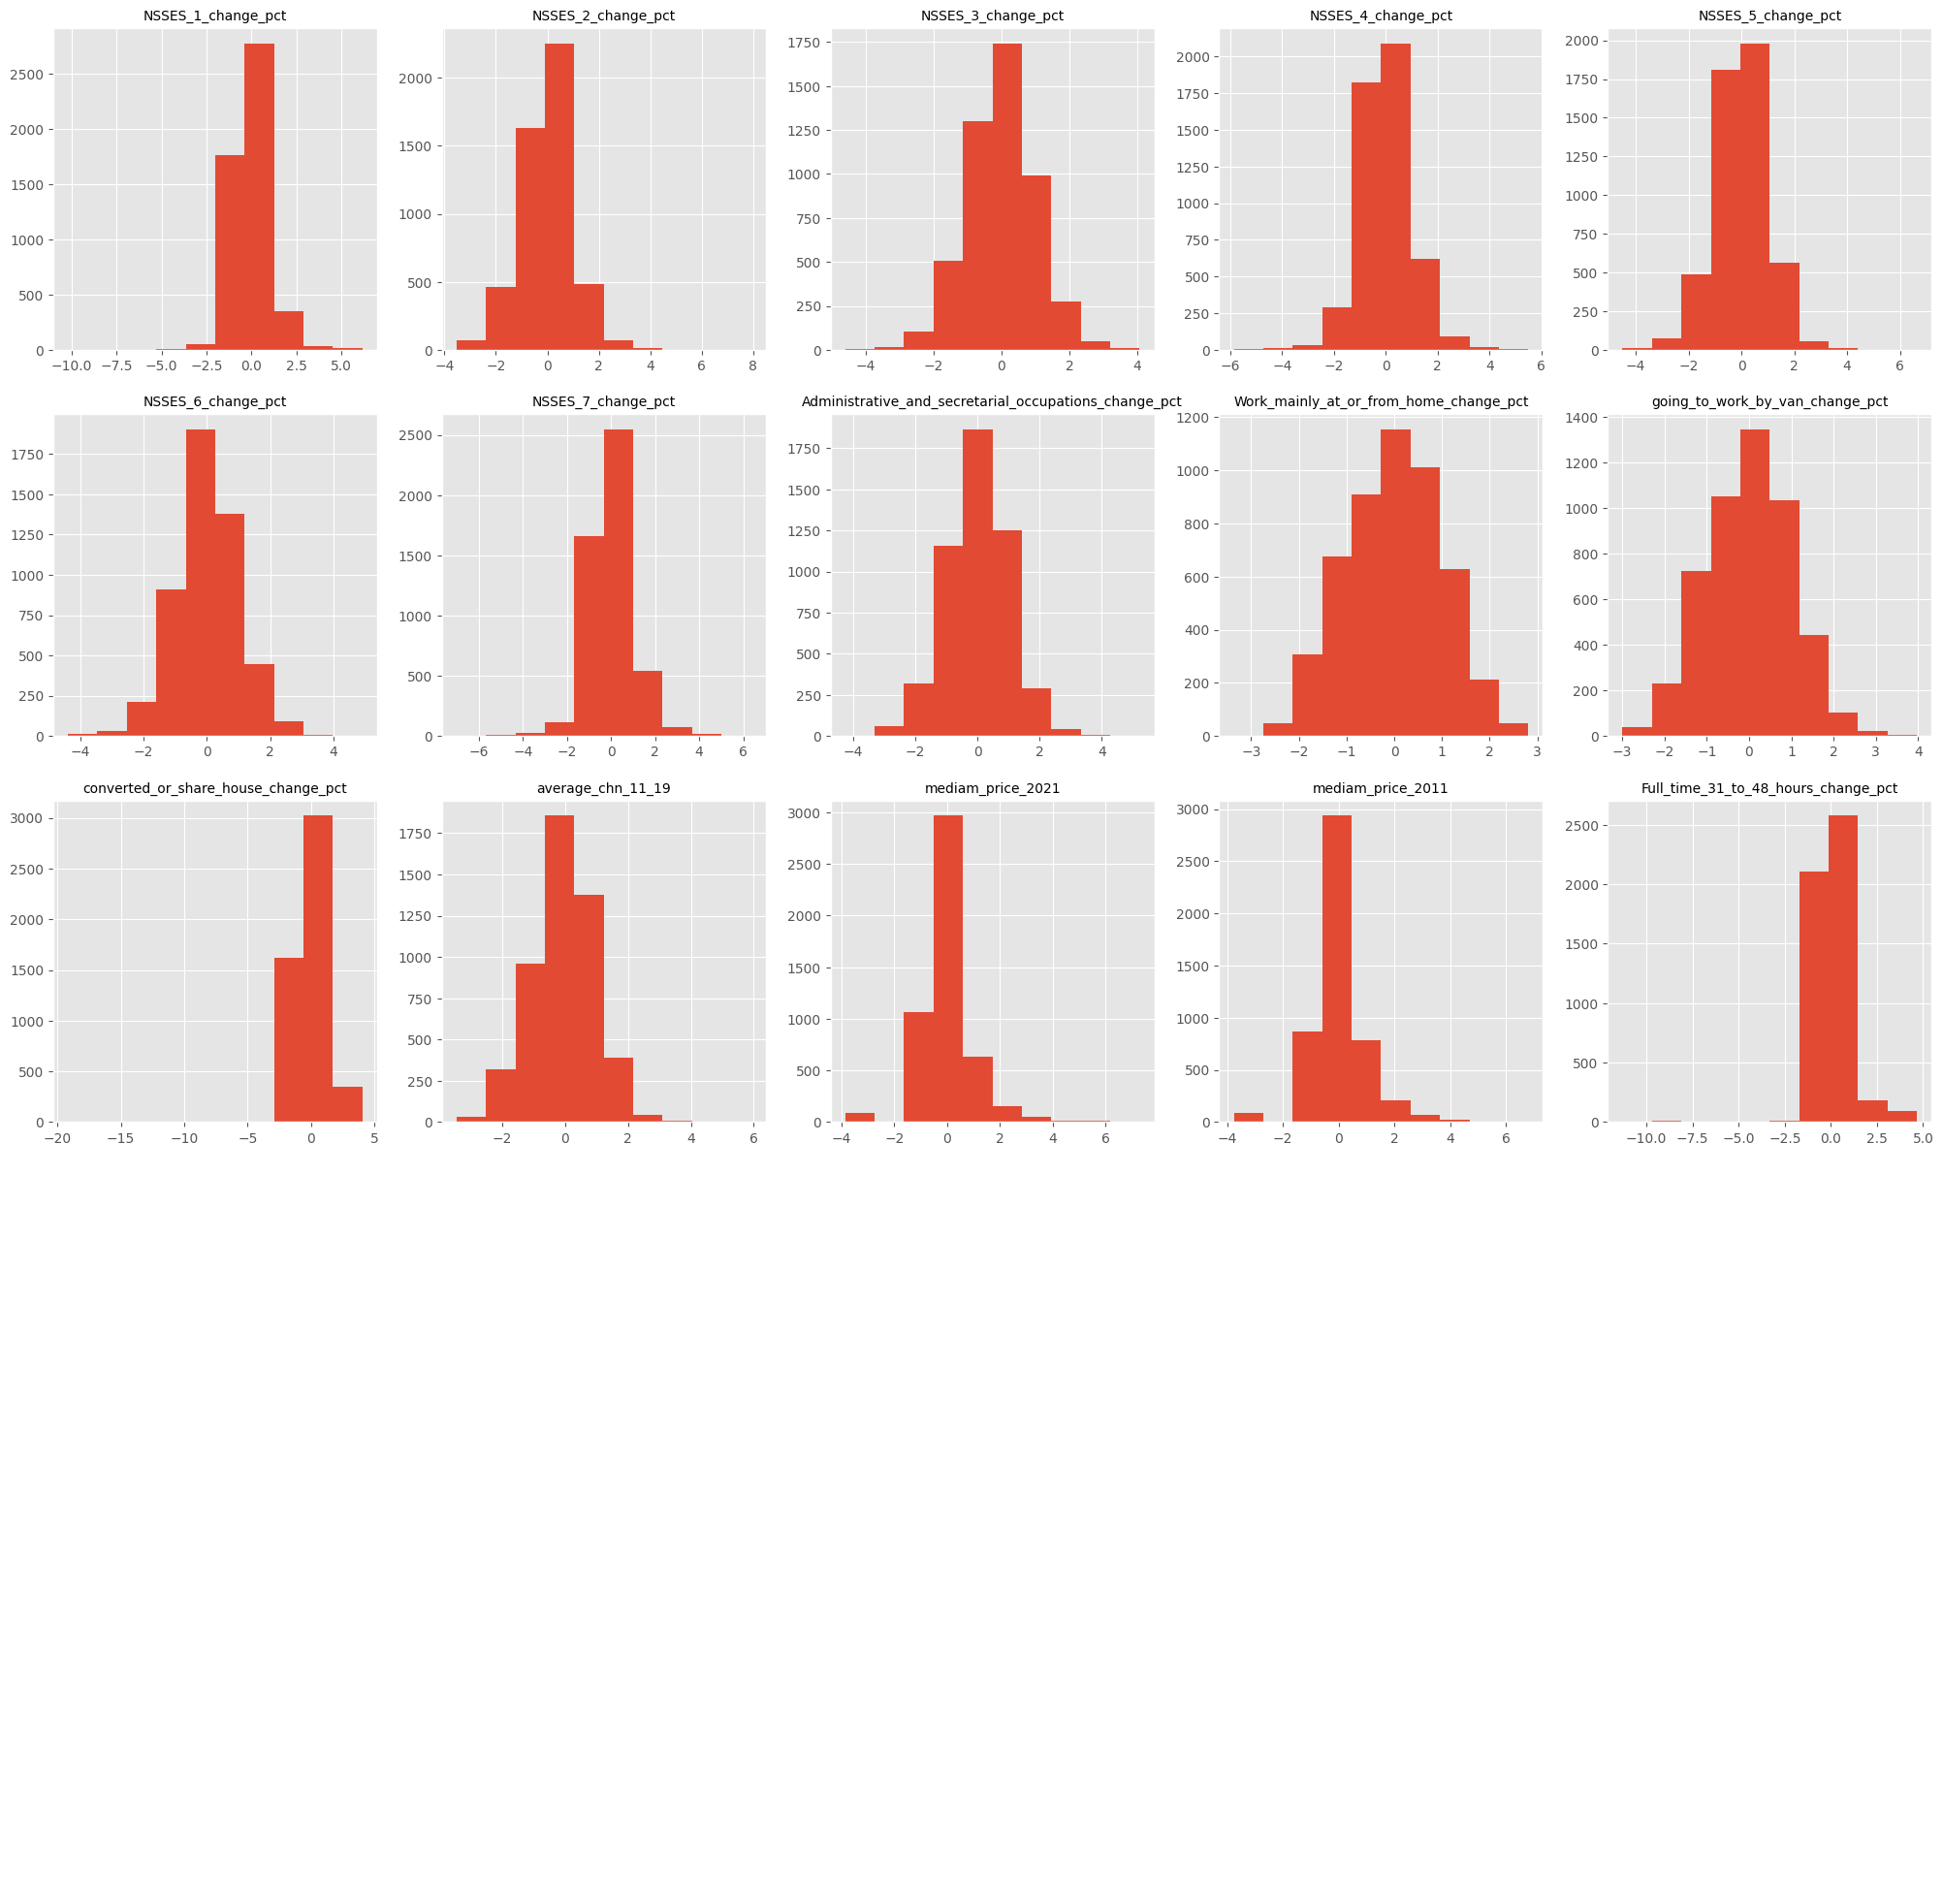

In [42]:
num_row = 5
num_col = 5
fig, axes = plt.subplots(nrows= num_row, ncols= num_col, figsize=(25, 25))

counter = 0
for i in range(num_row):
    for j in range(num_col):

        ax = axes[i][j]


        if counter < len( yeo_trans_data.columns):

            ax.hist(yeo_trans_data[ yeo_trans_data.columns[counter]], label='{}'.format( yeo_trans_data.columns[counter]))
            ax.set_title( yeo_trans_data.columns[counter], fontsize=10)

        else:
            ax.set_axis_off()

        counter += 1
        
plt.show()

In [43]:
robust_scaler = RobustScaler()
robust_data = robust_scaler.fit_transform(yeo_trans_data)
robust_data_df = pd.DataFrame(robust_data, columns=regression_columns)


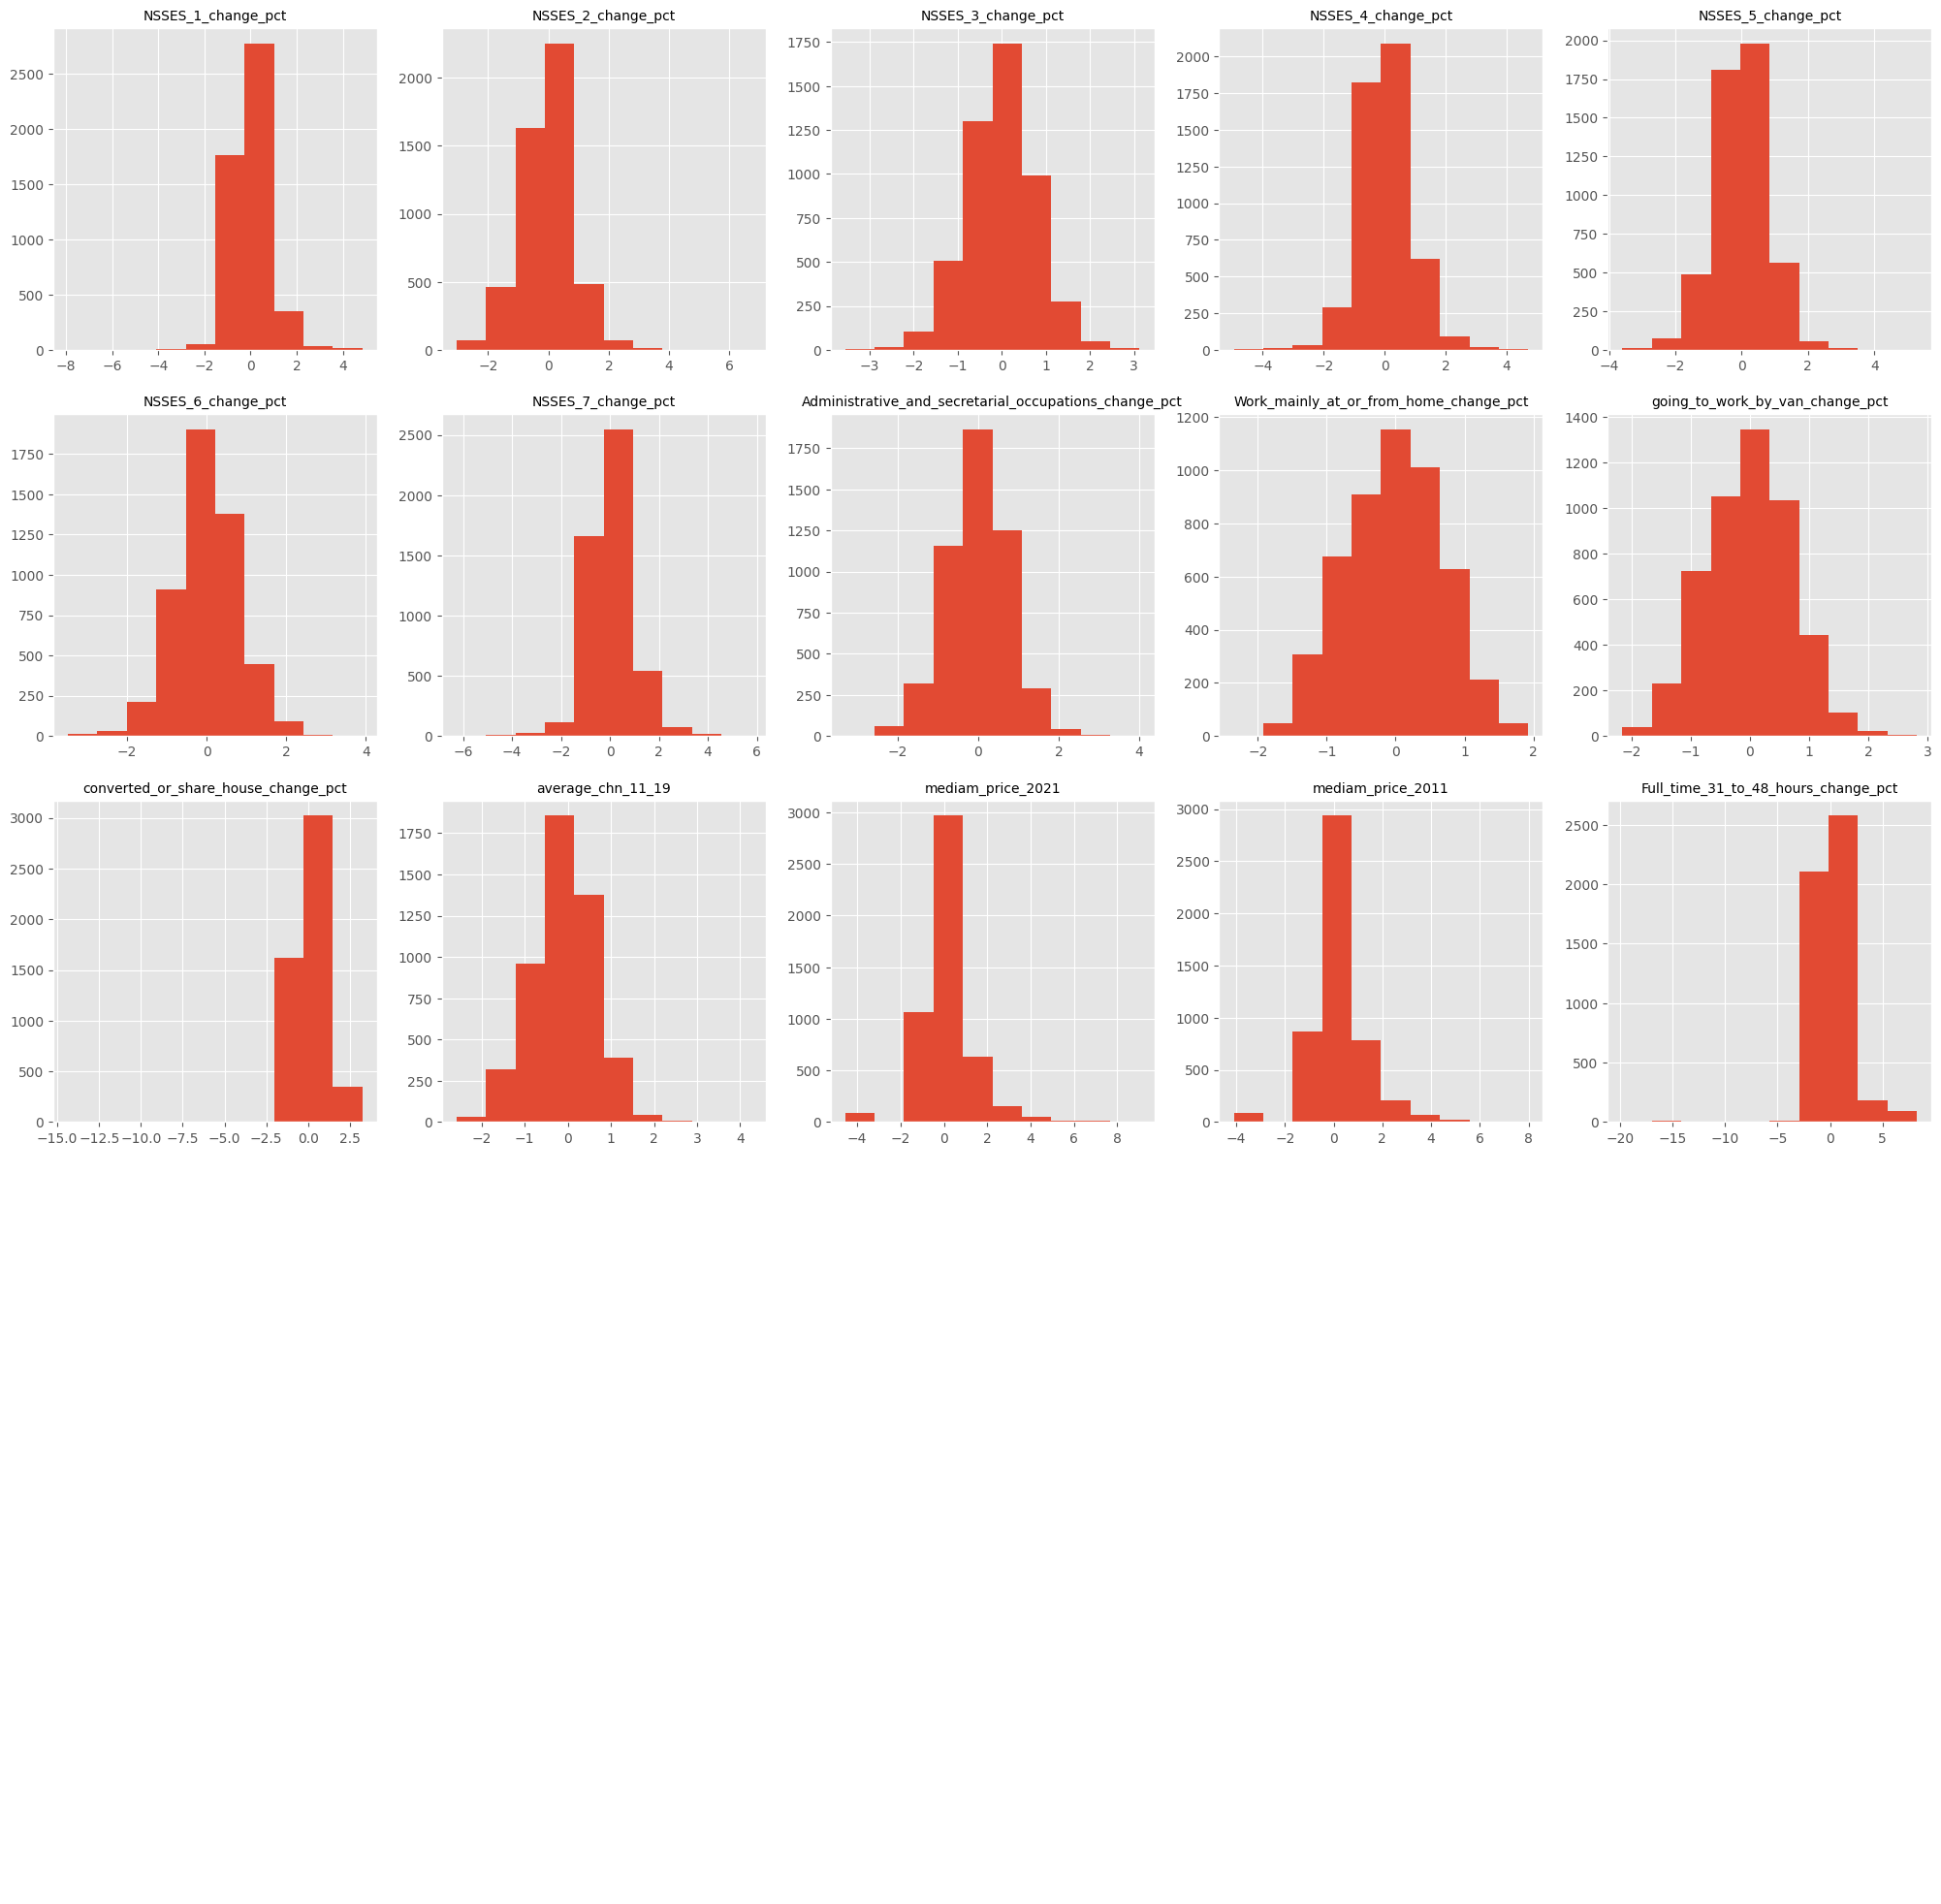

In [46]:
num_row = 5
num_col = 5
fig, axes = plt.subplots(nrows= num_row, ncols= num_col, figsize=(25, 25))

counter = 0
for i in range(num_row):
    for j in range(num_col):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len( robust_data_df.columns):

            ax.hist(robust_data_df.iloc[:, counter], label='{}'.format(robust_data_df.columns[counter]))
            ax.set_title(robust_data_df.columns[counter], fontsize=10)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1
        
plt.show()

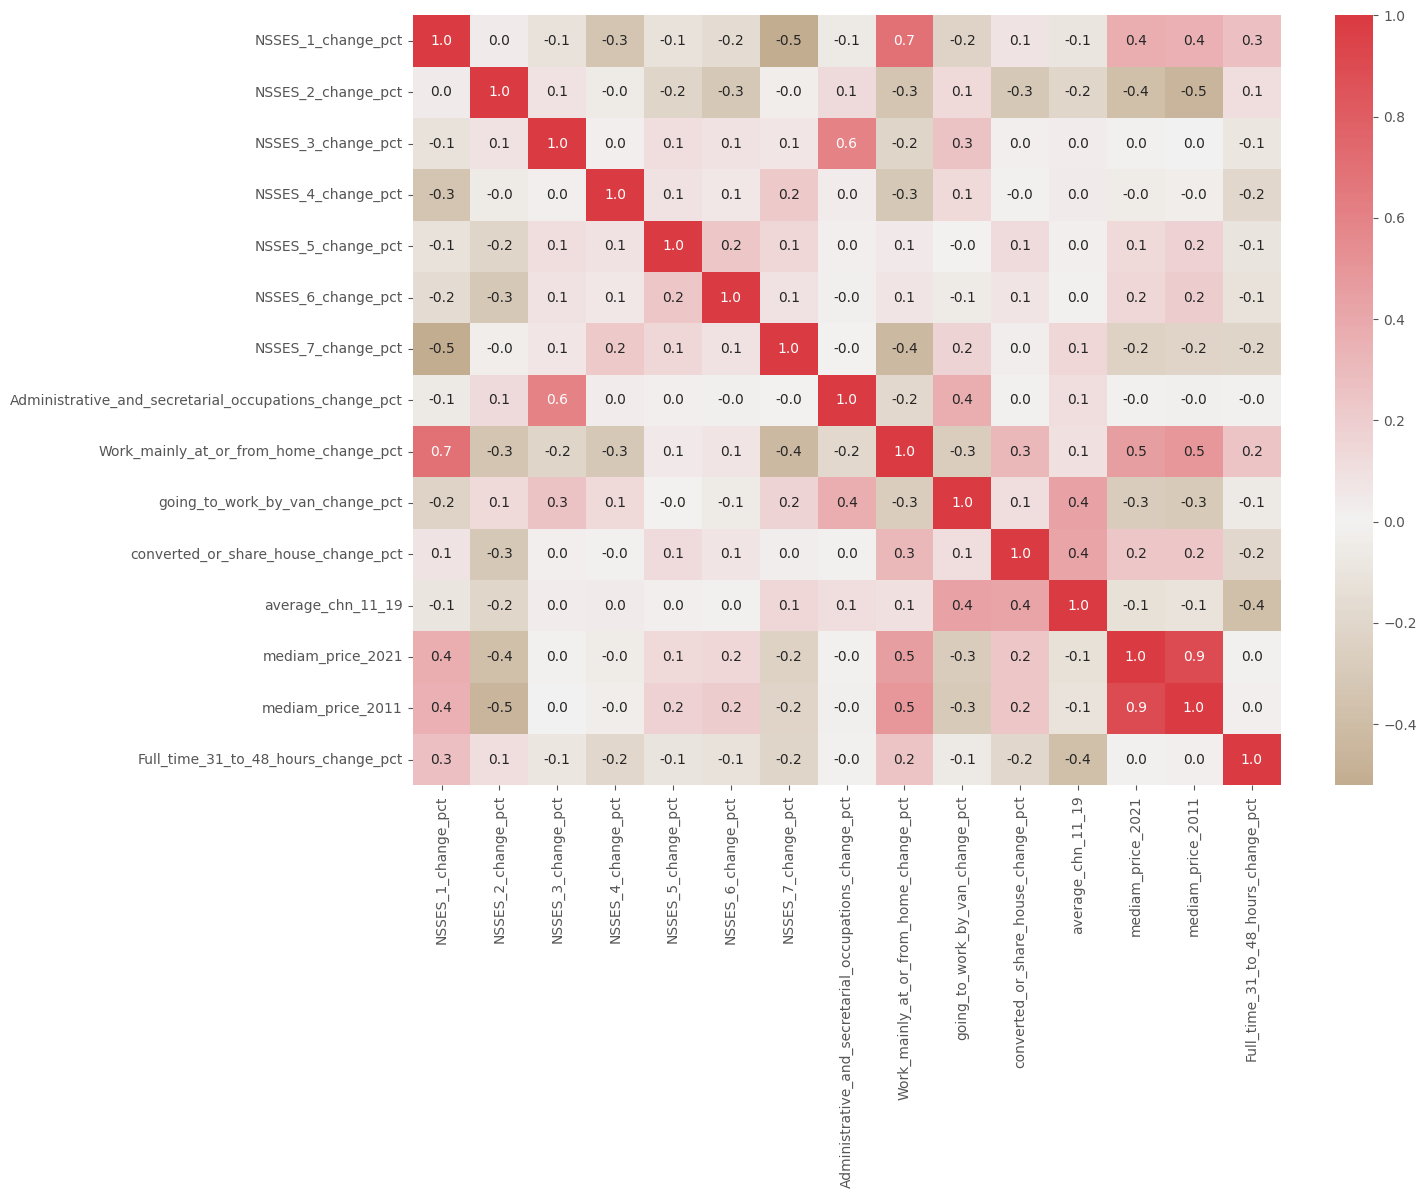

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
cmap = sns.diverging_palette(50, 11, as_cmap=True)

ax=sns.heatmap(robust_data_df.corr(), cmap=cmap, center=0, annot=True, fmt=".1f")

In [48]:
# robust_data_df = robust_data_df.drop(columns=["to_park_200m","to_park_500m"])

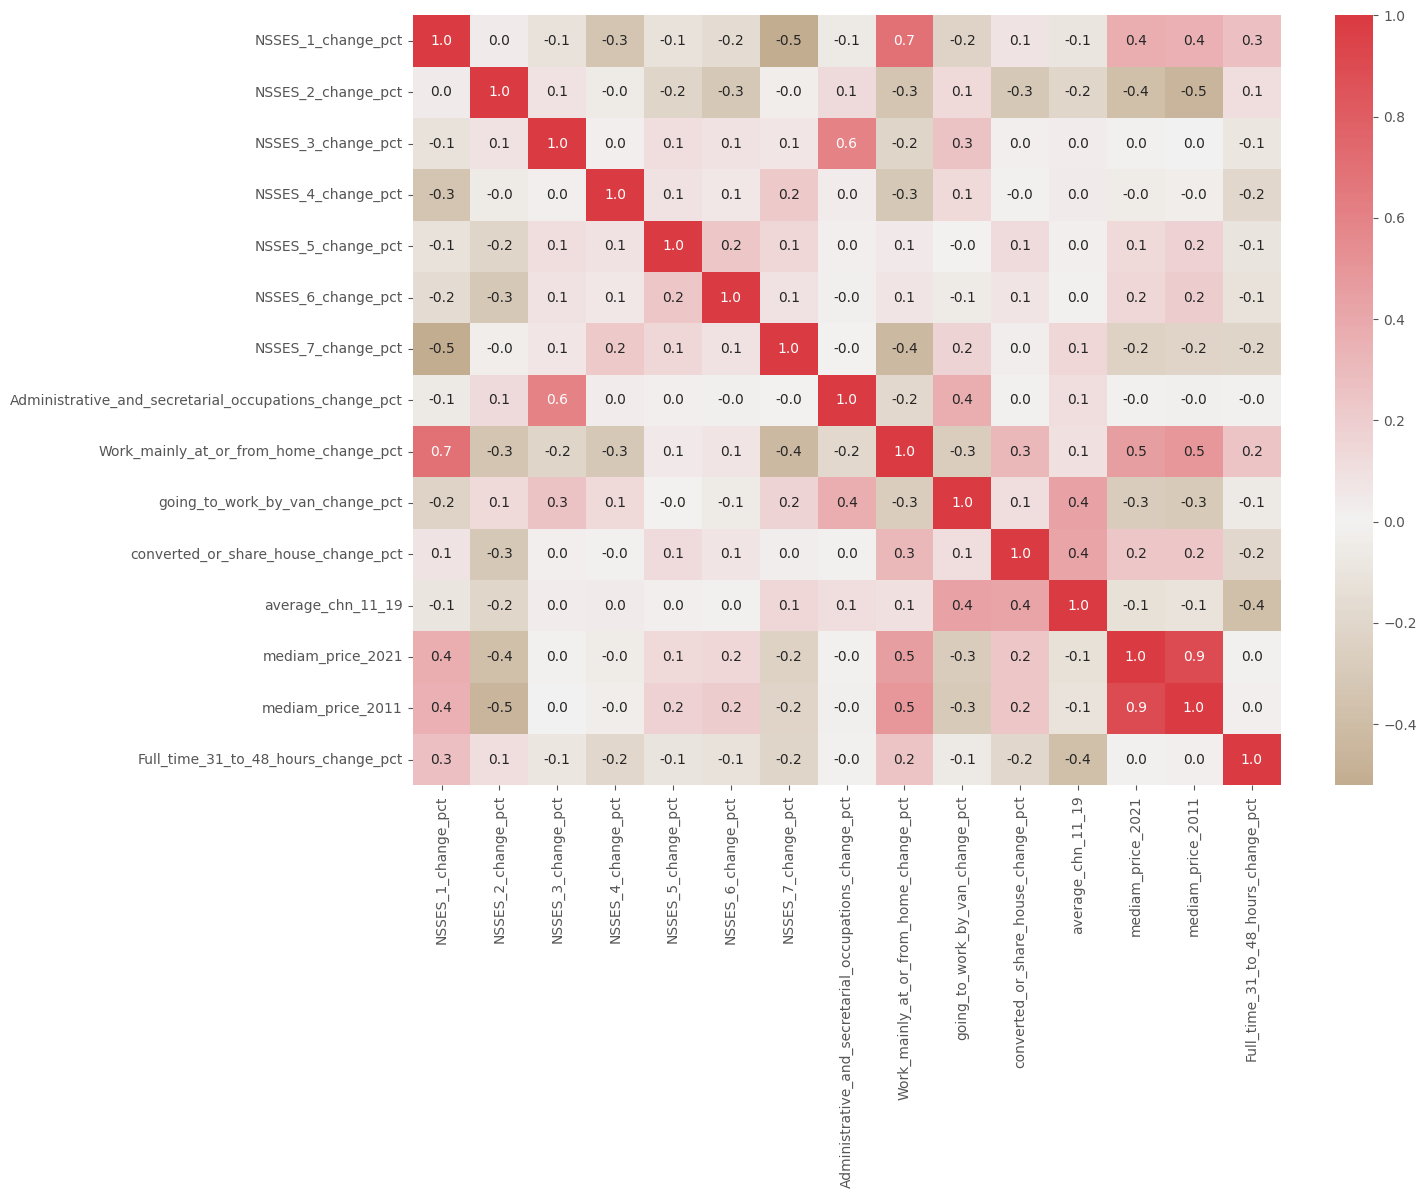

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
cmap = sns.diverging_palette(50, 11, as_cmap=True)

ax=sns.heatmap(robust_data_df.corr(), cmap=cmap, center=0, annot=True, fmt=".1f")

In [50]:
def logistic_regression_analysis(covariate_data, target_data, logistic_params):
    # Fit the logistic regression model
    logistic = LogisticRegression(**logistic_params)
    logistic.fit(covariate_data, target_data)

    # Output summary information
    X = sm.add_constant(covariate_data)  # add intercept
    logit_model = sm.Logit(target_data, X)
    result = logit_model.fit()
    return result.summary()




In [51]:
robust_data_df["gen"] = nor_data_psm['gen']

In [52]:
robust_data_df

,NSSES_1_change_pct,NSSES_2_change_pct,NSSES_3_change_pct,NSSES_4_change_pct,NSSES_5_change_pct,NSSES_6_change_pct,NSSES_7_change_pct,Administrative_and_secretarial_occupations_change_pct,Work_mainly_at_or_from_home_change_pct,going_to_work_by_van_change_pct,converted_or_share_house_change_pct,average_chn_11_19,mediam_price_2021,mediam_price_2011,Full_time_31_to_48_hours_change_pct,gen
0,0.379462,-1.016296,0.487608,0.714245,0.562211,0.847720,-0.434220,0.344512,1.108735,0.418300,-0.542273,-0.288361,1.299911,1.382565,0.714626,0
1,1.149594,-0.350790,-0.506361,-0.553875,0.090178,0.142035,-0.711215,-0.170504,1.334464,0.641746,-0.329757,-0.437120,1.224938,1.490476,0.076177,1
2,1.379076,0.872397,1.034234,0.640769,-0.217968,0.024463,-0.336105,0.737677,1.058653,0.593836,-0.412948,-0.142684,0.192112,0.976391,0.056121,1
3,-0.019104,-1.130482,-0.476205,-0.628463,-1.014959,-0.084893,0.855611,-0.693874,-0.036337,0.814893,-0.443010,-0.437120,-4.550999,-4.099416,0.634448,0
4,-1.170628,-0.315071,0.631900,0.753790,0.742457,0.352474,1.151436,0.321810,-0.886802,0.452607,-0.048369,1.279793,-0.389772,-0.165906,-0.624533,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,0.383861,-0.891196,0.649929,-0.245008,0.678432,0.457972,-0.477201,0.117406,-0.105181,0.077444,0.959951,1.162764,6.428741,5.646629,-8.049874,1
4990,0.614155,-1.214538,-1.321133,-0.153754,-0.059781,-0.222103,-0.538667,-1.081121,0.724413,0.107031,-1.207516,-1.373755,0.886790,1.595867,3.954460,0
4991,-1.524723,-1.581430,0.637910,0.431394,0.763893,1.929111,0.540900,0.162842,0.508256,0.376249,0.157469,-1.136156,0.886790,1.595867,3.416513,0
4992,0.998430,-0.959698,0.042169,-0.319235,-1.230099,-0.180623,-0.797774,-0.792553,0.266417,-0.009541,-0.352344,1.507322,4.849304,1.229552,-16.563530,1


In [53]:
robust_data_df_export = robust_data_df.copy()

In [54]:
robust_data_df_export["LSOA21CD"] = nor_data_psm["LSOA21CD"]

In [55]:
robust_data_df_export.to_csv('data/Output/gen_scenario_overlap.csv', index=False)

In [56]:
covariates = robust_data_df.iloc[:, :-1]
covariates

,NSSES_1_change_pct,NSSES_2_change_pct,NSSES_3_change_pct,NSSES_4_change_pct,NSSES_5_change_pct,NSSES_6_change_pct,NSSES_7_change_pct,Administrative_and_secretarial_occupations_change_pct,Work_mainly_at_or_from_home_change_pct,going_to_work_by_van_change_pct,converted_or_share_house_change_pct,average_chn_11_19,mediam_price_2021,mediam_price_2011,Full_time_31_to_48_hours_change_pct
0,0.379462,-1.016296,0.487608,0.714245,0.562211,0.847720,-0.434220,0.344512,1.108735,0.418300,-0.542273,-0.288361,1.299911,1.382565,0.714626
1,1.149594,-0.350790,-0.506361,-0.553875,0.090178,0.142035,-0.711215,-0.170504,1.334464,0.641746,-0.329757,-0.437120,1.224938,1.490476,0.076177
2,1.379076,0.872397,1.034234,0.640769,-0.217968,0.024463,-0.336105,0.737677,1.058653,0.593836,-0.412948,-0.142684,0.192112,0.976391,0.056121
3,-0.019104,-1.130482,-0.476205,-0.628463,-1.014959,-0.084893,0.855611,-0.693874,-0.036337,0.814893,-0.443010,-0.437120,-4.550999,-4.099416,0.634448
4,-1.170628,-0.315071,0.631900,0.753790,0.742457,0.352474,1.151436,0.321810,-0.886802,0.452607,-0.048369,1.279793,-0.389772,-0.165906,-0.624533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,0.383861,-0.891196,0.649929,-0.245008,0.678432,0.457972,-0.477201,0.117406,-0.105181,0.077444,0.959951,1.162764,6.428741,5.646629,-8.049874
4990,0.614155,-1.214538,-1.321133,-0.153754,-0.059781,-0.222103,-0.538667,-1.081121,0.724413,0.107031,-1.207516,-1.373755,0.886790,1.595867,3.954460
4991,-1.524723,-1.581430,0.637910,0.431394,0.763893,1.929111,0.540900,0.162842,0.508256,0.376249,0.157469,-1.136156,0.886790,1.595867,3.416513
4992,0.998430,-0.959698,0.042169,-0.319235,-1.230099,-0.180623,-0.797774,-0.792553,0.266417,-0.009541,-0.352344,1.507322,4.849304,1.229552,-16.563530


In [57]:
logistic_params = {'max_iter': 1000, 'solver': 'liblinear'}

summary = logistic_regression_analysis(covariates, robust_data_df['gen'], logistic_params)
print(summary)


Optimization terminated successfully.
         Current function value: 0.238177
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    gen   No. Observations:                 4994
Model:                          Logit   Df Residuals:                     4978
Method:                           MLE   Df Model:                           15
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                  0.4170
Time:                        08:58:29   Log-Likelihood:                -1189.5
converged:                       True   LL-Null:                       -2040.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                 